## SWIN Transformer Plant Disease Detector

### Import Libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
import os
import shutil
import random
import timm

from tqdm import tqdm
from torch import nn, optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchinfo import summary
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

### Initial Setup / Hyperparameters

In [2]:
training_data_directory = "PlantVillage_Split/training"
validation_data_directory = "PlantVillage_Split/validation"
test_data_directory = "PlantVillage_Split/test"
seed_value = 27

class_names = [
 'Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

number_of_classes = len(class_names)
batch_size = 32
image_size = 224
patch_size = 16
number_of_workers = 4
number_of_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

embedding_dimension = 768

training_split = .7
validation_split = .2
test_split = .1

### Split PlantVillage Data Into Training, Validation, and Test Folders

In [4]:
# Only Call Once and Only if Folders do not exist

clean_directory = "PlantVillage"
split_directory = "PlantVillage_Split"

# create sub sets
folders = ['training', 'validation', 'test']
for folder in folders:
    os.makedirs(os.path.join(split_directory, folder), exist_ok=True)

# loop over classes
for class_name in tqdm(class_names, desc="Split Classes"):
    path = os.path.join(clean_directory, class_name)
    images = os.listdir(path)
    random.shuffle(images)

    # determine number of images in the current class
    image_count = len(images)
    train_count = int(image_count * training_split)
    validation_count = int(image_count * validation_split)

    splits = {
        'training': images[:train_count],
        'validation': images[train_count:train_count + validation_count],
        'test': images[train_count + validation_count:]
    }

    # copy files to corresponding directory
    for split in splits:
        target_directory = os.path.join(split_directory, split, class_name)
        os.makedirs(target_directory, exist_ok=True)

        # copy file
        for image in splits[split]:
            source = os.path.join(path, image)
            destination = os.path.join(target_directory, image)
            shutil.copy(source, destination)


plit Classes: 100%|████████████████████████████████████████████████████████████████████| 38/38 [00:15<00:00,  2.49it/s]

### Data Transforms

In [5]:
# Augment training data with flips and rotation
training_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

validation_test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

### Load Datasets

In [6]:
training_dataset = datasets.ImageFolder(training_data_directory, transform=training_transform)
validation_dataset = datasets.ImageFolder(validation_data_directory, transform=validation_test_transform)

training_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True, num_workers=number_of_workers)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=number_of_workers)

### Configure Pretrained SWIN Transformer

In [7]:
model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_clases=number_of_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=.0001)

### Define Evaluation Function

In [8]:
def evaluate_model(loader, name: str):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    
    print(f"{name} Accuracy: {100 * correct / total:.2f}%")

### Model Summary

In [9]:
# Use torchinfo to display information about the model

summary(model, 
        input_size=(1, 3, image_size, image_size), 
        col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                             Input Shape               Output Shape              Param #
SwinTransformer                                    [1, 3, 224, 224]          [1, 1000]                 --
├─PatchEmbed: 1-1                                  [1, 3, 224, 224]          [1, 56, 56, 96]           --
│    └─Conv2d: 2-1                                 [1, 3, 224, 224]          [1, 96, 56, 56]           4,704
│    └─LayerNorm: 2-2                              [1, 56, 56, 96]           [1, 56, 56, 96]           192
├─Sequential: 1-2                                  [1, 56, 56, 96]           [1, 7, 7, 768]            --
│    └─SwinTransformerStage: 2-3                   [1, 56, 56, 96]           [1, 56, 56, 96]           --
│    │    └─Identity: 3-1                          [1, 56, 56, 96]           [1, 56, 56, 96]           --
│    │    └─Sequential: 3-2                        [1, 56, 56, 96]           [1, 56, 56, 96]           224,694
│    └─SwinTransformerStage: 2-4

### Train Pretrained SWIN Transformer on PlantVillage Dataset

In [10]:
for epoch in range(number_of_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in tqdm(training_dataloader, desc=f"Epoch {epoch+1}/{number_of_epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    print(f"Epoch {epoch+1}/{number_of_epochs}\n-----------------------------------------") 
    print(f"Training Loss: {running_loss / len(training_dataloader):.4f}")
    evaluate_model(training_dataloader, "Training")
    evaluate_model(validation_dataloader, "Validation")

Epoch 1/10: 100%|███████████████████████████████████████████████████████████████████| 1188/1188 [32:21<00:00,  1.63s/it]

Epoch 1/10
-----------------------------------------
Training Loss: 0.2436


Training Accuracy: 98.77%
Validation Accuracy: 98.26%


Epoch 2/10: 100%|███████████████████████████████████████████████████████████████████| 1188/1188 [32:19<00:00,  1.63s/it]

Epoch 2/10
-----------------------------------------
Training Loss: 0.0598


Training Accuracy: 99.29%
Validation Accuracy: 98.44%


Epoch 3/10: 100%|███████████████████████████████████████████████████████████████████| 1188/1188 [32:19<00:00,  1.63s/it]

Epoch 3/10
-----------------------------------------
Training Loss: 0.0379


Training Accuracy: 98.87%
Validation Accuracy: 98.09%


Epoch 4/10: 100%|███████████████████████████████████████████████████████████████████| 1188/1188 [32:20<00:00,  1.63s/it]

Epoch 4/10
-----------------------------------------
Training Loss: 0.0301


Training Accuracy: 99.67%
Validation Accuracy: 98.97%


Epoch 5/10: 100%|███████████████████████████████████████████████████████████████████| 1188/1188 [32:21<00:00,  1.63s/it]

Epoch 5/10
-----------------------------------------
Training Loss: 0.0344


Training Accuracy: 99.72%
Validation Accuracy: 99.02%


Epoch 6/10: 100%|███████████████████████████████████████████████████████████████████| 1188/1188 [32:12<00:00,  1.63s/it]

Epoch 6/10
-----------------------------------------
Training Loss: 0.0317


Training Accuracy: 99.22%
Validation Accuracy: 98.47%


Epoch 7/10: 100%|███████████████████████████████████████████████████████████████████| 1188/1188 [32:19<00:00,  1.63s/it]

Epoch 7/10
-----------------------------------------
Training Loss: 0.0211


Training Accuracy: 99.65%
Validation Accuracy: 99.17%


Epoch 8/10: 100%|███████████████████████████████████████████████████████████████████| 1188/1188 [32:21<00:00,  1.63s/it]

Epoch 8/10
-----------------------------------------
Training Loss: 0.0230


Training Accuracy: 99.61%
Validation Accuracy: 98.79%


Epoch 9/10: 100%|███████████████████████████████████████████████████████████████████| 1188/1188 [32:19<00:00,  1.63s/it]

Epoch 9/10
-----------------------------------------
Training Loss: 0.0206


Training Accuracy: 99.75%
Validation Accuracy: 98.81%


Epoch 10/10: 100%|██████████████████████████████████████████████████████████████████| 1188/1188 [32:11<00:00,  1.63s/it]

Epoch 10/10
-----------------------------------------
Training Loss: 0.0182


Training Accuracy: 99.79%
Validation Accuracy: 99.21%


### Save Model

In [11]:
torch.save(model.state_dict(), "swin_model_10_epochs_no_augmentation_normalization.pth")
print("saved.")

saved.


### Accuracy Visualization

### Evaluate Against Test Dataset

In [12]:
test_dataset = datasets.ImageFolder(test_data_directory, transform=validation_test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=number_of_workers)

model.eval()

total_predictions = []
total_labels = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, dim=1)
        probabilities = torch.softmax(outputs, dim=1)
        total_predictions.extend(predictions.cpu().numpy())
        total_labels.extend(labels.cpu().numpy())
        

### Model Metrics

#### Test Set Accuracy

In [14]:
test_accuracy = accuracy_score(total_labels, total_predictions)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 99.32%


#### Classification Report

In [15]:
print(classification_report(total_labels, total_predictions, target_names=class_names))

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.98      1.00      0.99        63
                                 Apple___Black_rot       1.00      1.00      1.00        63
                          Apple___Cedar_apple_rust       1.00      1.00      1.00        28
                                   Apple___healthy       1.00      0.99      0.99       165
                               Blueberry___healthy       0.97      1.00      0.98       151
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00       106
                 Cherry_(including_sour)___healthy       1.00      0.98      0.99        87
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       1.00      0.88      0.94        52
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       120
               Corn_(maize)___Northern_Leaf_Blight       0.94      0.99      0.

#### Confusion Matrix

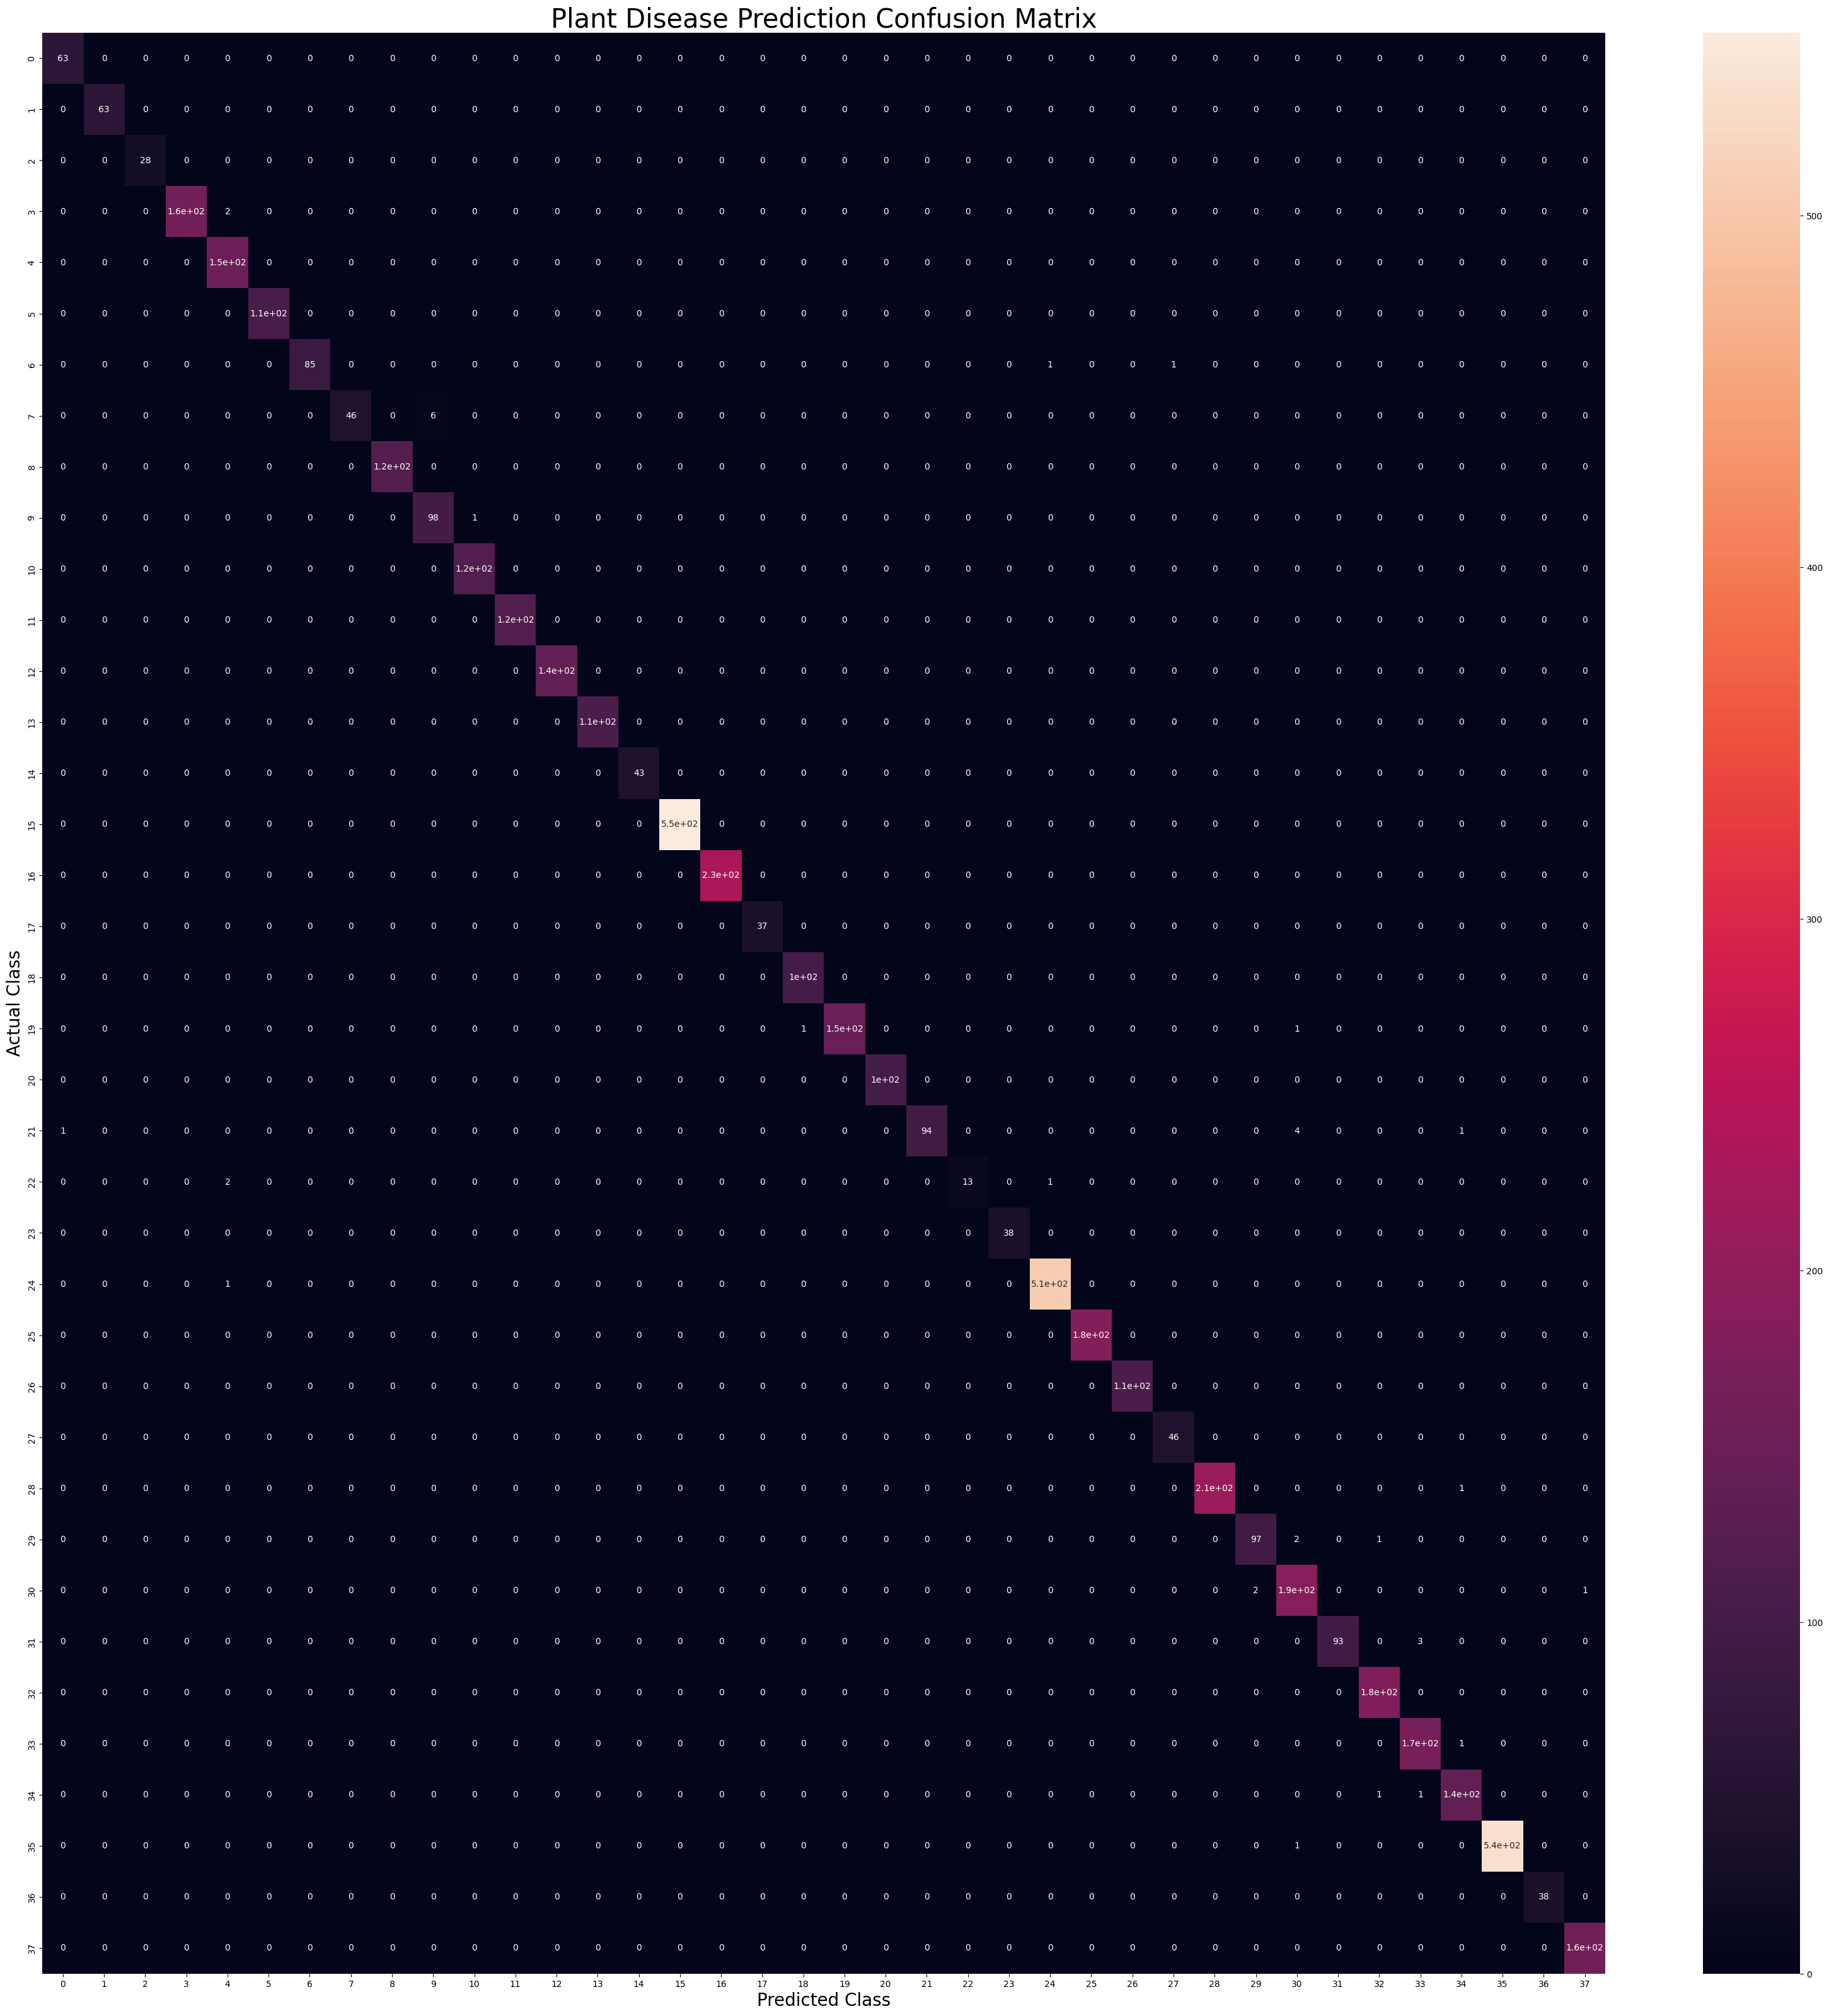

In [16]:
matrix = confusion_matrix(total_labels, total_predictions)

plt.figure(figsize=(40,40))
sns.heatmap(matrix, annot=True, annot_kws={'size':10})
plt.xlabel("Predicted Class", fontsize=20)
plt.ylabel("Actual Class", fontsize=20)
plt.title("Plant Disease Prediction Confusion Matrix", fontsize=30)
plt.show()

In [41]:
from collections import Counter

# Assuming `train_loader` is your DataLoader
class_counts = Counter()

# Iterate through the DataLoader to count instances per class
for images, labels in test_dataloader:
    class_counts.update(labels.numpy())  # or labels.tolist()

# Print the class distribution
for class_idx, count in class_counts.items():
    print(f"Class {test_dataloader.dataset.classes[class_idx]}: {count} samples")

Class Apple___Apple_scab: 63 samples
Class Apple___Black_rot: 63 samples
Class Apple___Cedar_apple_rust: 28 samples
Class Apple___healthy: 165 samples
Class Blueberry___healthy: 151 samples
Class Cherry_(including_sour)___Powdery_mildew: 106 samples
Class Cherry_(including_sour)___healthy: 87 samples
Class Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 52 samples
Class Corn_(maize)___Common_rust_: 120 samples
Class Corn_(maize)___Northern_Leaf_Blight: 99 samples
Class Corn_(maize)___healthy: 117 samples
Class Grape___Black_rot: 118 samples
Class Grape___Esca_(Black_Measles): 139 samples
Class Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 108 samples
Class Grape___healthy: 43 samples
Class Orange___Haunglongbing_(Citrus_greening): 552 samples
Class Peach___Bacterial_spot: 231 samples
Class Peach___healthy: 37 samples
Class Pepper,_bell___Bacterial_spot: 101 samples
Class Pepper,_bell___healthy: 149 samples
Class Potato___Early_blight: 100 samples
Class Potato___Late_blight: 100 sampl